In [1]:
import pygsp
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting
from torch_geometric.data import Data
plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10,8)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
import pickle
from torch_geometric.datasets import EllipticBitcoinDataset, Yelp
from torch_geometric.loader import DataLoader
dataset = EllipticBitcoinDataset(root = 'EllipticBitcoinDataset')    

In [2]:
"""RANDOM SAMPLING FROM DATASET"""
dataset = EllipticBitcoinDataset(root = 'EllipticBitcoinDataset')
#dataset = pickle.load(open('yelp.dat', 'rb'))
print(dataset)
import numpy as np
def sample_subset_removeunknown(data, factor, train):

    node_index = torch.where(data.y != 2)[0] #python convention
    node_amount = round(len(data.x[node_index])*factor)
    random_module = np.random.default_rng()   
    node_random = random_module.choice(a = len(data.x[node_index]), size = node_amount, replace = False)

    out_x = data.x[node_index][node_random]   #remove the unknown nodes and get random signal
    out_y = data.y[node_index][node_random]   #remove the unknown nodes and get random signal

    out_trainmask = torch.zeros(round(len(data.x[node_index])*factor), dtype = bool)  #creating a array of zero and then adding 1s for training mask
    out_trainmask[0: round(len(out_x)*train)] = True

    out_valmask = torch.zeros(round(len(data.x[node_index])*factor), dtype = bool)

    out_testmask = torch.ones(round(len(data.x[node_index])*factor), dtype = bool)
    out_testmask[0: round(len(out_x)*train)] = False

    out_edge_index = torch.tensor([[torch.where(node_1 == node_index)[0][0], torch.where(node_2 == node_index)[0][0]] for [node_1, node_2] in torch.transpose(data.edge_index,0,1) if (node_1 in node_index[0: round(len(data.y[node_index])*factor)]) and (node_2 in node_index[0: round(len(data.y[node_index])*factor)])])  #getting the edge index of the nodes

    new_data = Data(x = out_x, y = out_y, train_mask = out_trainmask, test_mask = out_testmask, val_mask = out_valmask, edge_index = torch.transpose(out_edge_index, 0 ,1).contiguous())
    return new_data
new_data = sample_subset_removeunknown(dataset[0], factor = 0.1, train = 0.45)
#new_data = sample_subset_removeunknown(new_data, factor = 0.1, train = 0.45)
print(new_data)
print("Total anomalies: " + str(new_data.y.sum()))
print("Amount of anomalies in training: "  + str((new_data.y*new_data.train_mask).sum()))

EllipticBitcoinDataset()
Data(x=[4656, 165], edge_index=[2, 3552], y=[4656], train_mask=[4656], test_mask=[4656], val_mask=[4656])
Total anomalies: tensor(459)
Amount of anomalies in training: tensor(204)


2023-05-30 16:42:07,773:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (4656 x 4656) is expensive. Consider decreasing n_eigenvectors or, if using the Fourier basis to filter, using a polynomial filter instead.


[ 0.00000000e+00 -1.93719289e-15 -1.59562899e-15 ...  1.99999999e+00
  1.99999999e+00  2.00000000e+00]


Text(0, 0.5, 'Eigenvalues')

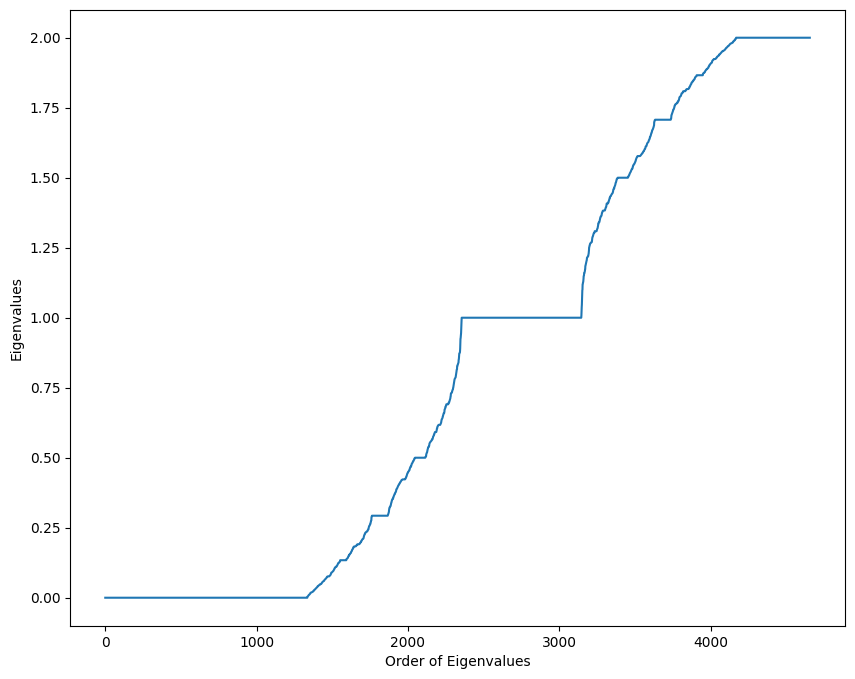

In [3]:
import numpy as np
import matplotlib as plt
adj_matrix = torch.zeros(len(new_data.x),len(new_data.x)).cpu()
for index, rows in enumerate(torch.transpose(new_data.edge_index, 0 ,1)):
            adj_matrix[rows[1]][rows[0]] = 1 
M = graphs.Graph(adj_matrix)
M.compute_laplacian('normalized')
M.compute_fourier_basis()
print(M.e)
x = np.arange(0, len(M.e))      #importing these lins from pygsp.plotting
y = M.e
fig, ax = plt.pyplot.subplots()
ax.plot(x,y)
ax.set_xlabel(r"Order of Eigenvalues")
ax.set_ylabel(r'Eigenvalues')

In [4]:
"""Finding the cutoff for highest eigenvalues(2 different methods)"""
cut_percent = 0.6
print(M.e)
cutoff_1 = M.e[round(len(M.e)*cut_percent)]
print(cutoff_1)
from numpy import trapz   #trapezoidal way of calculating AUC
total_area = trapz(M.e, dx = 1)  #distance between eigens being 1.
print(total_area)
for i in M.e:
    if trapz(M.e[M.e < i]) >= (total_area * cut_percent):
        print("Cutoff should be:" + str(i))
        cutoff_2 = i
        break

[ 0.00000000e+00 -1.93719289e-15 -1.59562899e-15 ...  1.99999999e+00
  1.99999999e+00  2.00000000e+00]
1.0000000000000002
3811.0000000017117
Cutoff should be:1.8466107552459046


In [34]:
"""STREAMLINED MODEL WITH CHEBY APPROXIMATION"""

import torch.nn.functional as F
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import zeros
from pygsp import graphs, filters
from scipy import sparse

def band_chebyshev_eigen_array(eigens, pass_band_high, stop_band_high, pass_band_low, stop_band_low, pass_ripple, stop_ripple):
    import numpy as np
    import math #for pi
    import torch
    
    eigens = np.array(eigens)
    all_value_high = np.array([])   #this is the value of filter at every eigenvalue
    all_value_low = np.array([]) 
    discrimination_factor = (((1-pass_ripple)**(-2) - 1)/(stop_ripple**(-2)-1))**(1/2)
    selectivity_factor = (1/(pass_band_high/stop_band_high))
    filter_order = round(np.arccosh(1/discrimination_factor)/np.arccosh(1/selectivity_factor))
    ripple = ((1-pass_ripple)**(-2) -1)**(1/2)
    k = np.arange(filter_order)
    pole_high = -1*np.sinh(1/filter_order*np.arcsinh(1/ripple))*np.sin((2*k + 1)*math.pi/(2*filter_order)) + 1j * 1 *np.cosh(1/filter_order*np.arcsinh(1/ripple))*np.cos((2*k+1)*math.pi/(2*filter_order)) #the backslash is to continue the line downwards
    filter_order_low = round(np.arccosh(1/discrimination_factor)/np.arccosh(1/(pass_band_low/stop_band_low)))
    k_low = np.arange(filter_order_low)
    pole_low = -pass_band_low*np.sinh(1/filter_order_low*np.arcsinh(1/ripple))*np.sin((2*k_low + 1)*math.pi/(2*filter_order_low)) + 1j*pass_band_low*np.cosh(1/filter_order_low*np.arcsinh(1/ripple))*np.cos((2*k_low + 1)*math.pi/(2*filter_order_low))
    for eigenvalue in eigens:
        numerator_high = 1
        denominator_high = 1
        numerator_high = np.prod(np.square(pole_high)*((eigenvalue)**(2))) #numerator value for every filter value
        denominator_high = np.prod((pass_band_high**2 + np.square(pole_high)*(eigenvalue**2)))
        numerator_low = 1
        denominator_low = 1
        numerator_low = np.prod(np.square(pole_low))
        denominator_low = np.prod(((1j*eigenvalue - pole_low)*(-1j*eigenvalue - pole_low)))
        if filter_order % 2 == 1:    #if K is odd
            value_high = numerator_high/denominator_high
        elif filter_order % 2 == 0:  #if K is even
            value_high = (1/(1 + ripple**2))*numerator_high/denominator_high
        all_value_high = np.append(all_value_high, value_high.real)
        if filter_order_low % 2 == 1:    #if K is odd
            value_low = numerator_low/denominator_low
        elif filter_order_low % 2 == 0:  #if K is even
            value_low = (1/(1 + ripple**2))*numerator_low/denominator_low
        all_value_low = np.append(all_value_low, value_low.real)
    

    all_value = 1 - (all_value_low + all_value_high)
    return torch.tensor(all_value, dtype = torch.float32)
    
def duc_filter(x):
    return band_chebyshev_eigen_array(eigens = x, pass_band_low = 0.3, stop_band_low = 0.4, pass_band_high = 1.7, stop_band_high = 1.6, pass_ripple = 0.01, stop_ripple = 0.01)
    
class GADModule(torch.nn.Module):
    def __init__(self, in_channels, out_channels, bias = True):
        super(GADModule, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = Linear(in_channels, out_channels, bias=False,
                          weight_initializer='glorot')
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
            
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        zeros(self.bias)
        
    def forward(self, data, graph):
        
        x, edge_index = data.x, data.edge_index
        
        x = self.lin(x)
        original_x = x[:, 0]

        chebyfilter = filters.Filter(graph, duc_filter)
        #x = chebyfilter.filter(x, method = 'chebyshev', order = 30)
        M = graph
        M.estimate_lmax()
        M_tensor = torch.tensor(M.L.toarray(), dtype = torch.float32)
        N = 31
        a_arange = [0, M.lmax]
        a1 = (a_arange[1] - a_arange[0]) / 2
        a2 = (a_arange[1] + a_arange[0]) / 2
        cheb_coeff = torch.zeros(N)
        tmpN = torch.arange(N)
        num = torch.cos(torch.pi * (tmpN + 0.5) / N)
        for o in range(N):
            cheb_coeff[o] = (2 / N) * torch.matmul(duc_filter(a1*num + a2), torch.cos(torch.pi * o * (tmpN + 0.5)/ N))
        cheb_coeff = torch.atleast_2d(cheb_coeff)
        Nscales, P = cheb_coeff.shape
        Nv = x.size()[1]
        r = torch.zeros((M.N * Nscales, Nv))
        tmpN = torch.arange(M.N, dtype = int)
        #this part invokes the signal. So the result is actually the filtered signal already I think.
        twf_old = x
        twf_cur = (M_tensor.matmul(x) - a2*x) / a1
        for i in range(Nscales):
            r[tmpN + M.N*i] = 0.5*cheb_coeff[i, 0]*twf_old + cheb_coeff[i, 1]*twf_cur
        factor = 2/a1 * (M_tensor - a2*torch.eye(M.N))
        for k in range(2, P):
            twf_new = factor.matmul(twf_cur) - twf_old
            for i in range(Nscales): #####i = 0
                r[tmpN + M.N*i] += cheb_coeff[i, k] * twf_new
            twf_old = twf_cur
            twf_cur = twf_new
        x[:, 0] = original_x
        out = x

        if self.bias is not None:
            out += self.bias
        
        out = F.dropout(out, training = self.training)
        return out

In [22]:
"""LOSS FUNCTION"""
import torch
import numpy as np
import torch.nn.functional as F
def my_loss(output, target, M):
    target = target[output[:, 1] != 0]      #adjusting to dropout. Assuming both columns would be 0 if one of them is here because writing the alternative is difficult.
    output = output[output[:, 1] != 0]
    output = F.softmax(output, dim = 1)
    output = output[:, 1]
    target[target == 0] = -1
    target[target == 2] = 0
    target[target == 1] = 1
    slack_variable = 0.1
    main_function = (torch.ones(len(output))*0.5 - output)*target + slack_variable           #slack variable is important to avoid the value going to 50 50%, in which it is default a normal node
    loss = torch.sum(torch.where(main_function > 0, main_function , 0), dtype = torch.float64) 
    return loss

tensor(246.1809, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(183.0811, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(153.1058, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(131.0914, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(122.2373, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(116.6897, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(98.5157, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(99.5031, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(80.9740, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(85.5234, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(74.7895, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(79.6187, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(75.0109, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(78.1491, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(73.4204, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(64.7777, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(68.1363, dt

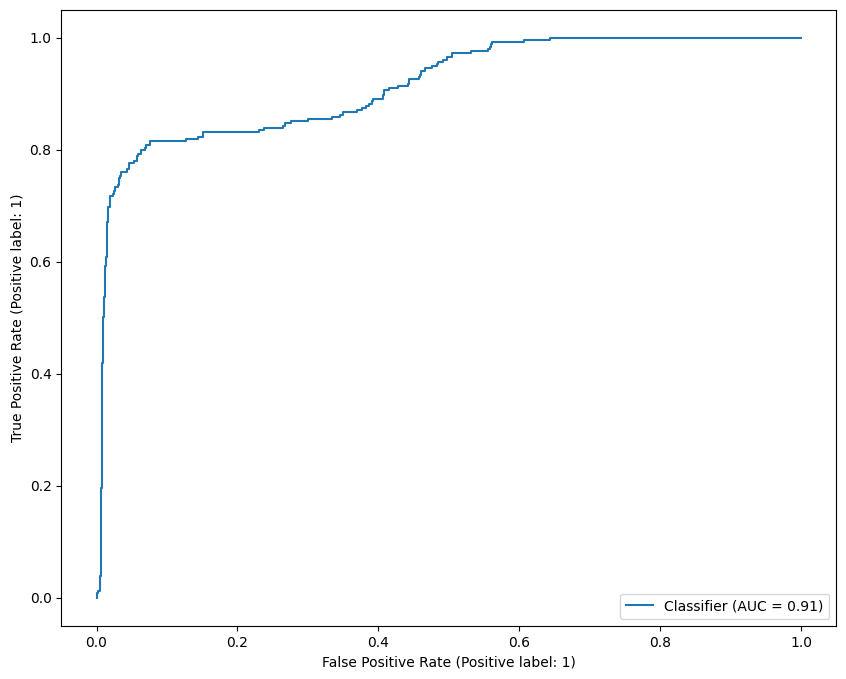

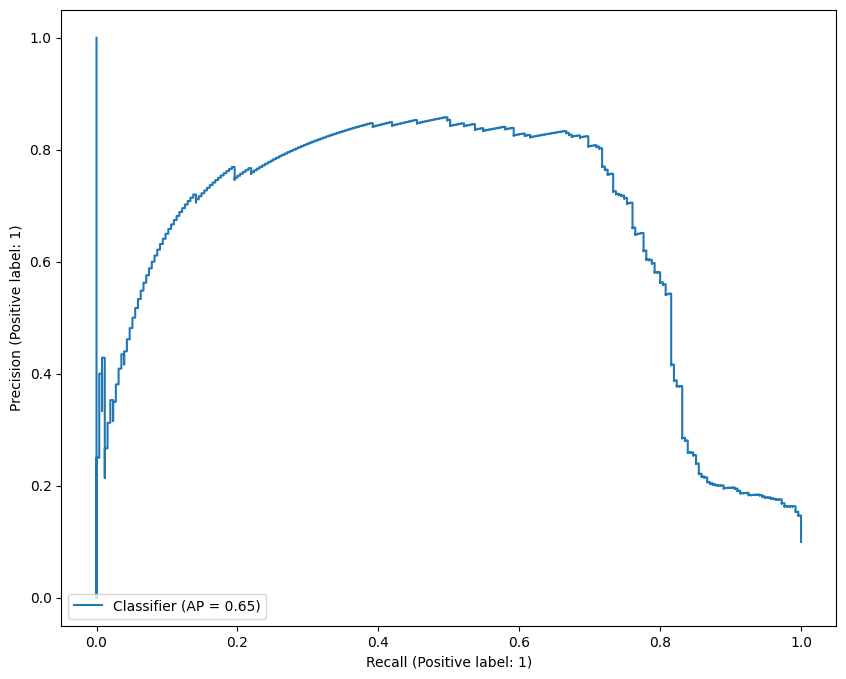

In [44]:
%%timeit -n 1 -r 1
from pygsp import graphs
import numpy as np
device = torch.device('cpu')         
model = GADModule(in_channels = new_data.num_node_features, out_channels = 2).to(device)                       
data = new_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.02, weight_decay = 5e-4)       
adj_matrix = torch.zeros(len(data.x),len(data.x)).cpu()
for index, rows in enumerate(torch.transpose(data.edge_index, 0 ,1)):
            adj_matrix[rows[1]][rows[0]] = 1 
M = graphs.Graph(adj_matrix)
M.compute_laplacian('normalized')
#M.compute_fourier_basis()

model.train()                 

for epoch in range(100):
    optimizer.zero_grad()           
    out = model(data, graph = M)                  
    loss = my_loss(out[data.train_mask], data.y[data.train_mask], M = M)     
    #loss_function = torch.nn.CrossEntropyLoss()
    #loss =  loss_function(out[data.train_mask], data.y[data.train_mask])
    print(loss)
    loss.backward()               
    optimizer.step()   

model.eval()             
pred = model(data, graph = M)
pred = F.softmax(pred, dim = 1)
print(pred[:, 1])
pred = pred.argmax(dim = 1)
#pred = pred[:, 0] #python convention
#pred[pred >= 0.95] = 1
#pred[pred != 1] = 0
print(pred[data.test_mask].sum())
print(data.y[data.test_mask].sum())
correct = (pred[data.test_mask]*data.y[data.test_mask]).sum()
print(correct)
acc = int(correct) / int(data.y[data.test_mask].sum())                           
print(f'Accuracy: {acc:.4f}')
from sklearn import metrics
pred = model(data, graph = M)
pred = F.softmax(pred, dim = 1)
pred = pred[:, 1]
y_score = pred[data.test_mask].detach().numpy()
y_data_fitformetric = data.y[data.test_mask]
roc_display = metrics.RocCurveDisplay.from_predictions(y_data_fitformetric, y_score)
##############Trying to take average################
score = metrics.roc_auc_score(y_data_fitformetric, y_score)
print("ROC score: " + str(score))

precision, recall, _ = metrics.precision_recall_curve(y_data_fitformetric, y_score)
auc_pr = metrics.auc(recall, precision)
display = metrics.PrecisionRecallDisplay.from_predictions(y_data_fitformetric, y_score)
print("PR score: " + str(auc_pr))

In [51]:
%%timeit -n 1 -r 1

"""IMPROVING THE ORIGINAL BY ADDING AN ACCURACY CHECK AFTER EVERY EPOCH TO FIND THE BEST EPOCH TO STOP"""
from pygsp import graphs
import numpy as np
from sklearn import metrics
device = torch.device('cpu')         
model = GADModule(in_channels = new_data.num_node_features, out_channels = 2).to(device)                       
data = new_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.02, weight_decay = 5e-4)       
adj_matrix = torch.zeros(len(data.x),len(data.x)).cpu()
for index, rows in enumerate(torch.transpose(data.edge_index, 0 ,1)):
            adj_matrix[rows[1]][rows[0]] = 1 
M = graphs.Graph(adj_matrix)
M.compute_laplacian('normalized')
#M.compute_fourier_basis()
results_roc = []
results_pr = []
model.train()                 

for epoch in range(100):
    optimizer.zero_grad()           
    out = model(data, graph = M)

    #This part is to check the accuracy of each epoch
    pred = F.softmax(out, dim = 1)
    pred = pred[:, 1]
    y_score = pred[data.test_mask].detach().numpy()
    y_data_fitformetric = data.y[data.test_mask]
    score = metrics.roc_auc_score(y_data_fitformetric, y_score)           
    precision, recall, _ = metrics.precision_recall_curve(y_data_fitformetric, y_score)      
    auc_pr = metrics.auc(recall, precision)
    results_roc.append(score)
    results_pr.append(auc_pr)

    loss = my_loss(out[data.train_mask], data.y[data.train_mask], M = M)    
    #loss_function = torch.nn.CrossEntropyLoss()
    #loss =  loss_function(out[data.train_mask], data.y[data.train_mask])
    print(loss)
    loss.backward()               
    optimizer.step()   


model.eval()       



pred = model(data, graph = M)
pred = F.softmax(pred, dim = 1)
solve = pred.argmax(dim = 1)
pred = pred[:, 1]
y_score = pred[data.test_mask].detach().numpy()
y_data_fitformetric = data.y[data.test_mask]
roc_display = metrics.RocCurveDisplay.from_predictions(y_data_fitformetric, y_score)
##############Trying to take average################
score = metrics.roc_auc_score(y_data_fitformetric, y_score)
precision, recall, _ = metrics.precision_recall_curve(y_data_fitformetric, y_score)
auc_pr = metrics.auc(recall, precision)
display = metrics.PrecisionRecallDisplay.from_predictions(y_data_fitformetric, y_score)
results_roc.append(score)
results_pr.append(auc_pr)


print(solve[data.test_mask].sum())
print(data.y[data.test_mask].sum())
correct = (solve[data.test_mask]*data.y[data.test_mask]).sum()
print(correct)
acc = int(correct) / int(data.y[data.test_mask].sum())                           
print(f'Accuracy: {acc:.4f}')

print("Best ROC score: " + str(max(results_roc)) + "   At epoch: " + str(results_roc.index(max(results_roc))))
print("Best PR score: " + str(max(results_pr)) + "   At epoch: " + str(results_pr.index(max(results_pr))))

tensor(289.5462, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(226.8912, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(190.3476, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(167.1331, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(134.2441, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(120.0356, dtype=torch.float64, grad_fn=<SumBackward0>)
